In [201]:
import functions
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, butter, iirnotch, filtfilt, sosfilt, find_peaks
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB
from copy import deepcopy
import scipy.stats as stats
from picard import Picard
from sklearn.decomposition import FastICA as skFastICA
import neurokit2 as nk


In [2]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))

In [158]:
data = functions.array_from_TDMSgroup("patients/P050/P050_S01_D2024-06-13_G39.tdms", "R001")
#filtered_data = functions.butter_filter(data)
copied_data = deepcopy(data)

In [159]:
def bandpass_filter(dd, order=5):
    sos = butter(order, [1, 40], btype='band', output='sos', fs=1000)
    #band_stop=butter(bsto,bstfc,btype='bandstop',output='sos',fs=fs)
    data = deepcopy(dd)
    for i in range(data.shape[1]):
        data[:,i] = sosfilt(sos, data[:,i])
    return data

bp_data = bandpass_filter(copied_data[5000:, 1:])

In [160]:
ica = Picard(n_components=30, fun='logcosh', whiten='unit-variance', max_iter=400, tol=1e-5, ortho=True, extended=True)
filtered_data_np = np.array(bp_data)
ica_applied = ica.fit_transform(filtered_data_np)


/Users/z3rd3n/SS24/fMCG/.fmcg_venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


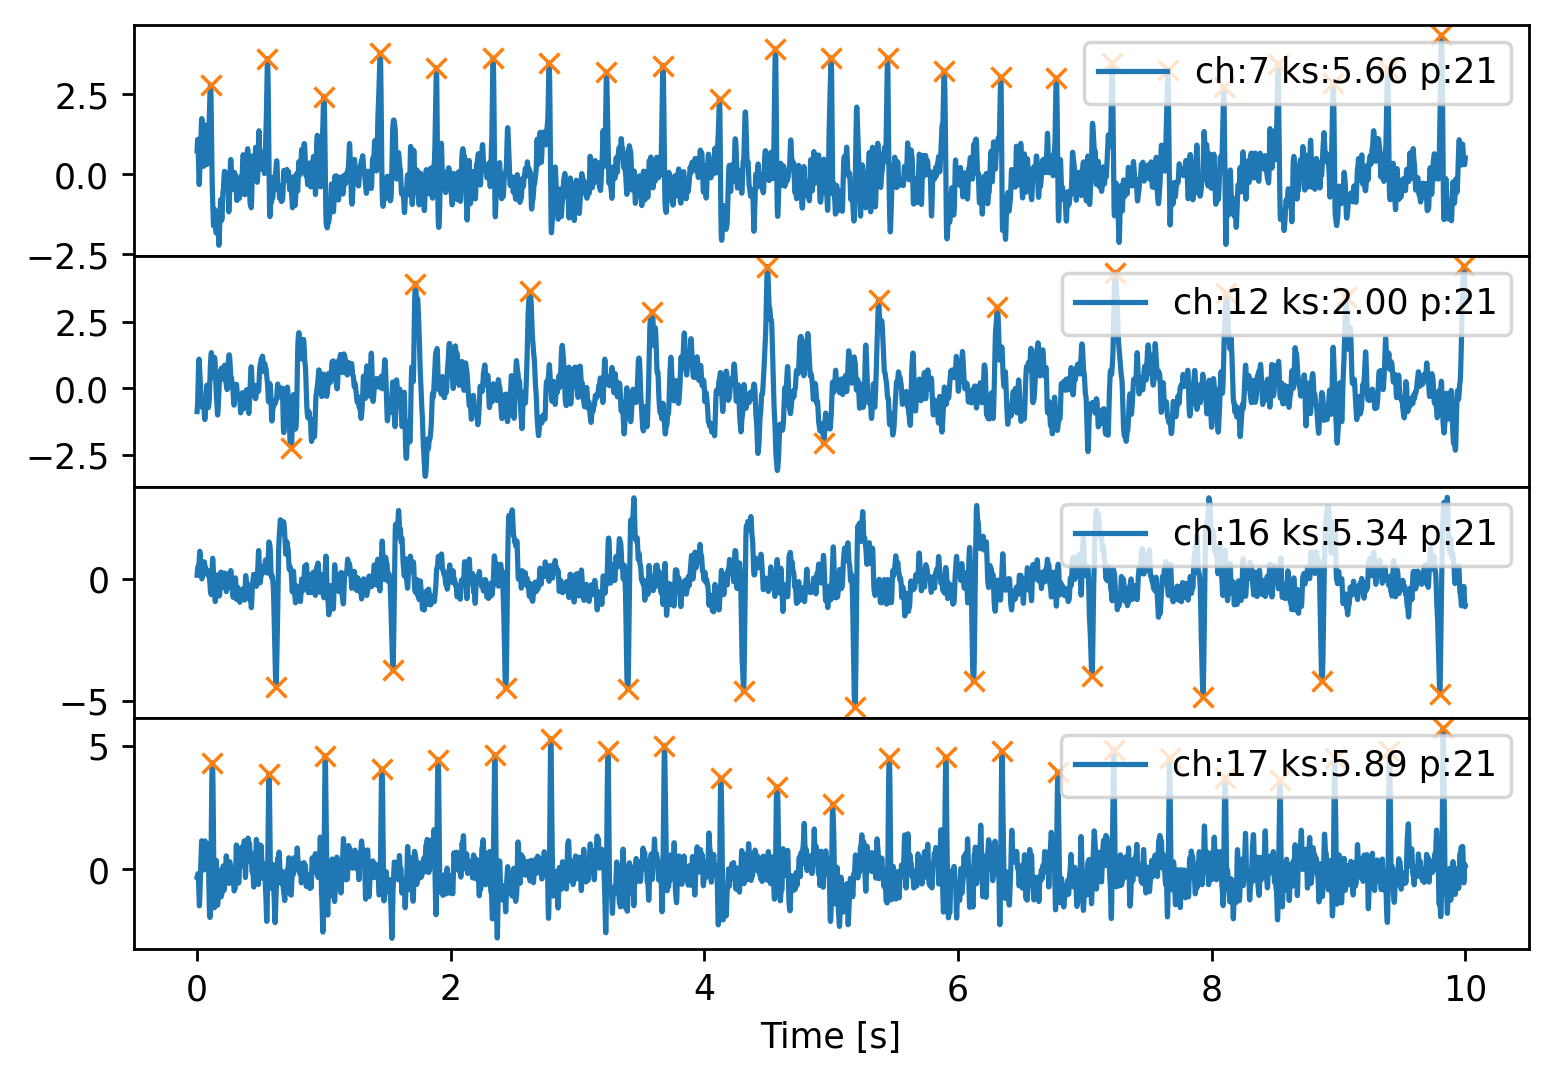

In [209]:
kurtosis_values = [stats.kurtosis(ica_applied[:, j]) for j in range(ica_applied.shape[1])]

# Identify channels with kurtosis > 2
channels_to_plot = [j for j, kurt in enumerate(kurtosis_values) if kurt > 2 and kurt < 330]

# Set up the subplot grid based on the number of channels to plot
fig, ax = plt.subplots(len(channels_to_plot), 1, sharex=True, figsize=(1.8 * len(channels_to_plot), 1.2 * len(channels_to_plot)), dpi=250)
fig.subplots_adjust(hspace=0)

# Plot only the channels with kurtosis > 2
for i, j in enumerate(channels_to_plot):
    signal = ica_applied[offset:offset+span, j]
    peaks, properties = find_peaks(np.abs(signal), distance = 400, height=2) 
    ax[i].plot(ica_applied[offset:offset+span, j], label=f'ch:{j} ks:{kurtosis_values[j]:.2f} p:{len(idx)}')
    ax[i].plot(peaks, signal[peaks], "x")
    ax[i].legend(loc=1)

# Configure the x-axis formatter for the last subplot
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')

# Display the plot
plt.show()

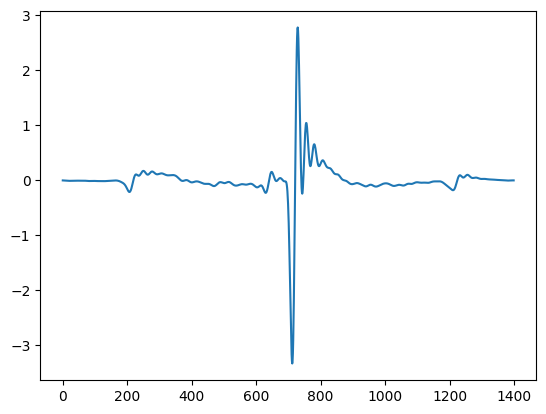

In [7]:
beat, detect = apply_hosd(ica_applied[:,13], window_size) 
plt.plot(beat)

In [ ]:
RR, sigma_RR, peaks, popt_RRs, yy, xx = functions.detect_beats(detect)
try:
    savgol_median = savgol_filter(np.diff(peaks), 41, 3)
    avg_peaks_list = peaks[np.where(np.square((np.diff(peaks) - savgol_median) / sigma_RR) < 2)]
except:
    avg_peaks_list = peaks

peaks = avg_peaks_list
if len(peaks)<3:
    print('skipped (low peak count)')
else:
    slice_box, avg_mean,worked = functions.avg_based_QRScomplex(ica_applied[:,13], peaks,sigma_RR, box_size=window_size)
    segmentation_data=functions.waveform_plot(np.array(slice_box), time_axis-window_size/2, add_lines=[avg_mean,beat], sideplot=[xx,yy,popt_RRs,RR,sigma_RR,0])

218
skipping 18 and 4
skipping 34 and 4
skipping 50 and 4
skipping 58 and 4
skipping 68 and 2
skipping 81 and 4
skipping 85 and 2
skipping 102 and 2
skipping 144 and 4
skipping 169 and 2
skipping 176 and 2
skipping 181 and 2
skipping 184 and 2
skipping 189 and 2
skipping 205 and 2
skipping 213 and 2


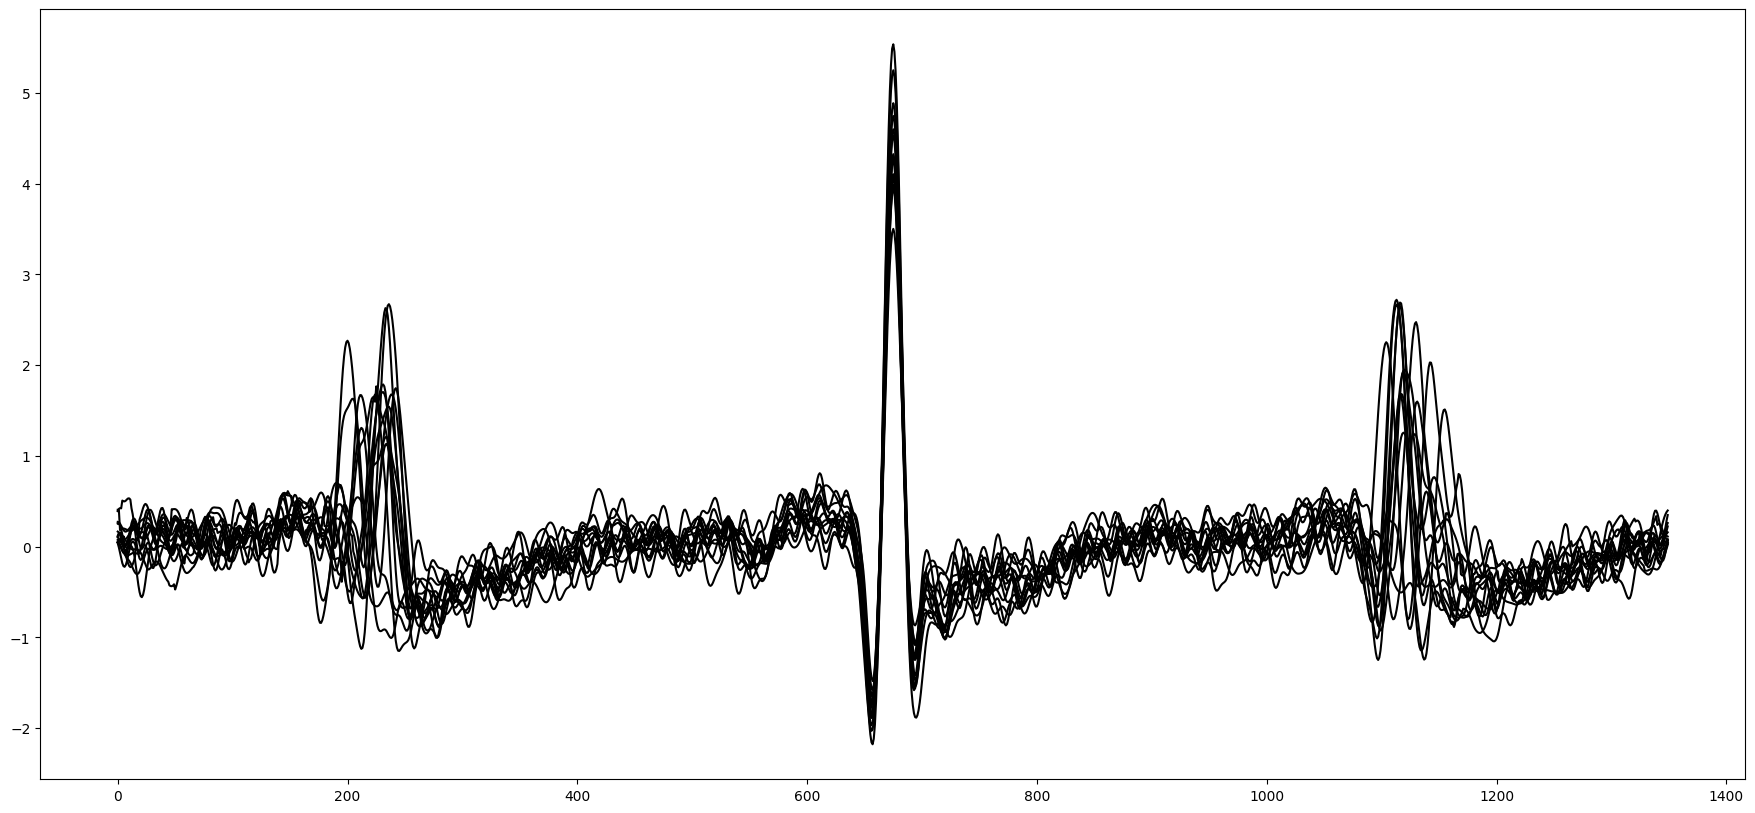

In [229]:
segment_samples = 1350
#beat, detect = apply_hosd(ica_applied[:,28], segment_samples)
#ecg_data = detect

ecg_data = ica_applied[:, 17]
num_segments = len(ecg_data) // segment_samples
print(num_segments)
avg_segment = []
avg_num = 15
plt.figure(figsize=[22,10])
for i in range(1,num_segments):
    start_idx = i * segment_samples
    end_idx = start_idx + segment_samples
    segment = ecg_data[start_idx:end_idx]
    peaks, _ = find_peaks(np.abs(segment), height=2, distance= 400)
    if len(peaks) == 3:
        segment = np.roll(segment, segment_samples//2-peaks[1])
    else:
        print(f"skipping {i} and {len(peaks)}")
        continue
    avg_segment.append(segment)
    if i % avg_num == 0:
        plt.plot(np.mean(np.array(avg_segment), axis = 0), color = 'k')
        avg_segment = []

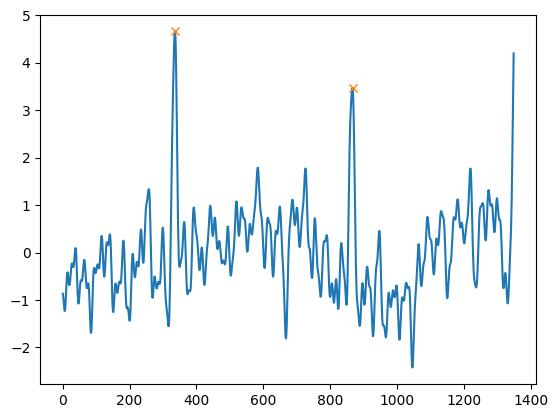

In [223]:
import neurokit2 as nk

start_idx = 205 * segment_samples
end_idx = start_idx + segment_samples
segment = ecg_data[start_idx:end_idx]
peaks, _ = find_peaks(segment, height=2, distance= 400)
plt.plot(segment)
plt.plot(peaks, segment[peaks], 'x')

In [183]:
print(idx)

[487 952]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len

from notebooks_freq.polycoherence import polycoherence

N = 10001
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, freq2, bispec = polycoherence(detect[5000:40000], norm=None, fs=1000, **kw)

df1 = freq1[1] - freq1[0]
df2 = freq2[1] - freq2[0]
freq1 = np.append(freq1, freq1[-1] + df1) - 0.5 * df1
freq2 = np.append(freq2, freq2[-1] + df2) - 0.5 * df2
bispec = np.abs(bispec)

# Map the output values between 0 and 1
bispec_norm = (bispec - np.min(bispec)) / (np.max(bispec) - np.min(bispec))

plt.figure()
plt.pcolormesh(freq2, freq1, bispec_norm, vmin=0, vmax=1)
plt.xlabel('freq (Hz)')
plt.ylabel('freq (Hz)')
plt.xlim(0,40)
plt.ylim(0,40)
plt.axis('off')
plt.savefig('maternal.png', bbox_inches='tight', pad_inches=0)


In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nmse

# Load the images
fetal = cv2.imread('fetal.png', cv2.IMREAD_GRAYSCALE)
maternal = cv2.imread('maternal.png', cv2.IMREAD_GRAYSCALE)

# Ensure the images are the same size
fetal = cv2.resize(fetal, (maternal.shape[1], maternal.shape[0]))

# Compute SSIM
ssim_value = ssim(fetal, maternal)

print(f"SSIM: {ssim_value}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Load your ECG signal here
# For this example, let's assume you have a 1D numpy array called ecg_signal

# Define the wavelet and the level of decomposition
wavelet = 'bior4.4'
level = 8

# Perform the wavelet decomposition
coeffs = pywt.wavedec(bp_data[5000:,10], wavelet, level=level)

# Plot the wavelet coefficients
fig, ax = plt.subplots(level, 1, figsize=(12, level*2.54))
for i in range(level):
    ax[i].plot(coeffs[i])
    ax[i].set_title(f'Level {i+1}')
plt.tight_layout()
plt.show()


In [ ]:
# Perform the wavelet decomposition
coeffs = pywt.wavedec(bp_data[5000:, 10], wavelet, level=level)

# Thresholding function
def threshold_coeffs(coeffs, threshold):
    coeffs_thresh = coeffs.copy()
    coeffs_thresh[1:] = [pywt.threshold(c, 0, mode='soft') for c in coeffs_thresh[1:]]
    return coeffs_thresh

# Determine the threshold
threshold = np.median(np.abs(coeffs[-1])) / 0.6745 * np.sqrt(2 * np.log(len(bp_data[5000:, 10])))

# Threshold the coefficients
coeffs_thresh = threshold_coeffs(coeffs, threshold)

# Reconstruct the signal from the thresholded coefficients
denoised_signal = pywt.waverec(coeffs_thresh, wavelet)

# Plot the original and denoised signals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(bp_data[5000:6000, 10])
ax[0].set_title('Original Signal')
ax[1].plot(denoised_signal[5000:6000])
ax[1].set_title('Denoised Signal')
plt.tight_layout()
plt.show()


In [ ]:
print(coeffs[1].shape)

In [ ]:
coeffs[1] = savgol_filter(coeffs[1], 101, 3)
coeffs[0] = savgol_filter(coeffs[0], 5, 3)

reconstructed_signal = pywt.waverec(coeffs, wavelet)

plt.plot(reconstructed_signal[offset:offset+3000])

In [ ]:
import numpy as np
import pywt


# Choose a wavelet and level for the decomposition
wavelet = 'bior4.4'  # Daubechies 4 wavelet, commonly used for ECG signals
level = 5  # Decomposition level

# Perform 2D Stationary Wavelet Transform
coeffs_list = []

for channel in range(bp_data.shape[1]):
    coeffs_list.append(pywt.swt(bp_data, wavelet, level=level))


In [ ]:
print(coeffs_list[2].shape)